In [1]:
%matplotlib notebook


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import math as mth
import random as rand
import statistics as s
import healpy as hp
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.basemap import Basemap   #for some reason getting an error on this one, gonna comment it out!
from matplotlib import cm, colors
from healpy import newvisufunc

In [3]:
def length(v):
    return mth.sqrt(np.dot(v, v))

def angle(v1, v2):

    return mth.acos(np.dot(v1, v2) / (length(v1) * length(v2)))

def response(A,B):
    #meant to imitate the response of the detectors for effective area vs. angle, found to be around .76
    return pow(abs(np.cos(angle(A,B))),0.76)


def chimaker(chiterms,Ndets): 
    #separate out all of the individual chi squared terms, and add each together. 

    a,b,c,d=np.array_split(chiterms,Ndets)
    ab=np.add(a,b)
    cd=np.add(c,d)
    chisquareds=(np.add(ab,cd)) 


    return chisquareds

def solver(detsvals,detnorms,bottheta,toptheta,botphi,topphi,n,bgrd):
#this function uses a chi squared minimizer over a given range to identify the theta,phi,
#and Ao values which correspond to the minimum chi squared and thus localized source. 
    confidence = []
    chiterms = []
    thecon = []
    phicon = []
    for s in range(len(detsvals)):     
        oa=np.deg2rad(np.linspace(bottheta,toptheta,n))  #range of thetas to sample
        ob=np.deg2rad(np.linspace(botphi,topphi,n)) #phi
        Aofit=np.linspace(0,1000,26)  
        for sa in range(len(oa)): 
            for sb in range(len(ob)):
                for sc in range(len(Aofit)):
                    #make sure it fits within the acceptable range
                    if oa[sa]>=0 and oa[sa]<=np.pi and ob[sb]>=0 and ob[sb]<=2*np.pi:
                        CHIsourceang=[oa[sa],ob[sb]]
                        CHIsourcexyz = hp.ang2vec(CHIsourceang[0],CHIsourceang[1])
                        CHIsep=angle(CHIsourcexyz,detnorms[s])                                           
                        if CHIsep<np.pi: 
                            chi=Aofit[sc]*response(CHIsourcexyz,detnorms[s])+bgrd
                            #print("Chi test angle"+str(CHIsourcexyz))
                            #print("detector"+str(dets[s]))
                            #print("chi sometiems"+str(chi))
                            #print("separation here, is it okay? " +str(np.rad2deg(CHIsep)))

                            #this produces nan error, se
                            
                        else:
                            chi=0            
                        if detsvals[s]>0:   #if there is a signal in the detector 
                            chiterm=((chi-detsvals[s])**2/detsvals[s])
                        else:    #if not, just zero 
                            chiterm=10000
                    else: 
                        chiterm=10000 #some large #, just to note that it definitely isn't right angle 
                                                                       
                                    
                    chiterms.append(chiterm)   #this is an array of EVERY SINGLE term, need to split in pieces and add element by element...
    
    chisquareds=chimaker(chiterms,len(detsvals))
    chimin=np.amin(chisquareds)
    chisquareds=list(chisquareds)
    thetaloc = np.rad2deg(oa[int((chisquareds.index(chimin)-(chisquareds.index(chimin) % (len(ob)*len(Aofit))))/(len(ob)*len(Aofit)))])
    philoc = np.rad2deg(ob[int(((chisquareds.index(chimin) % (len(ob)*len(Aofit)))-(chisquareds.index(chimin) % (len(Aofit))))/len(Aofit))])
    Aoguess=Aofit[int((chisquareds.index(chimin) % (len(ob)*len(Aofit)))  % len(Aofit))]
    #print(Aoguess)
    #print(thetaloc,philoc)
    
    return thetaloc,philoc,chisquareds,chimin,Aoguess



Variables to call in the function that runs through a simulation:

Signal strength
Background
Number of detectors (tilt of each detector)
sky position? => should think about this more, can do one version of sim that just does the entire sky, and then evaluates effectiveness of detector based on that, and one simulation that takes a specific sky position that I may or may not care about in particular. 

In [16]:
def mynewsim(NSIDE,samplesize,burst,background,Ndets,tiltA,tiltB,alternating=False):
#full sky simulation for a given number of dete
    
    
    start_time = time.time()

    zenith=[0,0]  #set zenith of the system

    if Ndets==4: 
        print("Running through with 4 detectors,")
        print("")  #make some space so the printed result is easier...
        if alternating == False:
            print("not alternating in tilt. Testing for all bent by " + str(tiltA) + " degrees.")
            print("")
            tilt1=np.deg2rad(tiltA)   #4 detectors
            tilt4=tilt3=tilt2=tilt1
        elif alternating == True:
            print("with alternating tilts. Testing for " + str(tiltA) + " by " + str(tiltB) + " degrees.")
            print("")
            tilt3 = tilt1 = np.deg2rad(tiltA)
            tilt4 = tilt2 = np.deg2rad(tiltB)
    
        Anorm = hp.ang2vec(zenith[0]+tilt1,zenith[1])
        Bnorm = hp.ang2vec(zenith[0]+tilt2,zenith[1]+np.pi/2)
        Cnorm = hp.ang2vec(zenith[0]+tilt3,zenith[1]+np.pi)
        Dnorm = hp.ang2vec(zenith[0]+tilt4,zenith[1]+3*np.pi/2)
        detectors = [Anorm,Bnorm,Cnorm,Dnorm] 
            
#now I have all of my tilts, might as well as define the normal of each detector! 
    
    else: 
        print("Sorry, if you're looking for a simulation involving anything besides 4 scintillators, try https://github.com/nkasmanoff/Localizing-Simulations !")
#now to go through the sky 
    pixels = hp.nside2npix(NSIDE)

    x = samplesize  #sample size at each sky position. 
    localizationerrors = []  #localization uncertanties in total
    print("Testing a sky of " + str(pixels) +" pixels,")
    print("where it's sampling each sky location " + str(x) + " times.")
    print("Using burst(s) of " + str(burst) + " counts with background of " + str(background) + " counts.")
    for i in range(pixels):
        sourceang=hp.pix2ang(NSIDE,i)
        print("")
        print("Testing at " + str(np.rad2deg(sourceang)))
        print("")
        sourcexyz = hp.ang2vec(sourceang[0],sourceang[1]) #cartesian position of the burst
        loop = 0
        locunc = [] #array of localization uncertainty at a given sky position, cleared out for each test location. 
        while loop<x:
            detcounts = []
            for j in range(len(detectors)):
                sep=angle(sourcexyz,detectors[j])
                if sep<np.pi/2:
                    dtheory=burst*response(sourcexyz,detectors[j]) #expected number of counts in A, will be pickd up
                else:
                    dtheory=0
                counts = dtheory+background
                unccounts=np.sqrt(counts)
                detactual=rand.gauss(counts,unccounts)
                if detactual-background<0:
                    detactual=0
                detcounts.append(detactual)  #the number of counts in each detector as a result 
             #   print("For detector " + str(j+1) + ", reovered a signal of " + str(detactual) + " counts.")

            coarsethetaloc,coarsephiloc,coarsechisquareds,cmin,coarseAo = solver(detcounts,detectors,0,90,0,360,20,background)  #runs through big range with few points, easy to pinpoint from here
            finethetaloc,finephiloc,finechisquareds,fmin,fineAo = solver(detcounts,detectors,coarsethetaloc-7,coarsethetaloc+7,coarsephiloc-7,coarsephiloc+7,12,background)                      
      

            if finethetaloc>180:
                print("It recovered something over the horizon, skip!")
                break
                #finethetaloc=np.pi
            elif finethetaloc<0:
               
                print("It recovered something under the horizon, skip!")
                break
            
            recpos = [finethetaloc,finephiloc] #reconstructed position. 
            acvec=hp.ang2vec(np.deg2rad(finethetaloc),np.deg2rad(finephiloc))  #xyz position of the localized source
            locunc.append(angle(sourcexyz,acvec))  #angular separation between the source and the calculated sky position, 8° or less! 
         #   print("Recovered as "+ str(recpos))
         #   print("Ang sep of " + str(np.rad2deg(angle(sourcexyz,acvec))) +" deg.")
            
            loop+=1
        localizationerrors.append(np.rad2deg(s.mean(locunc)))
        print("Avg ang sep of " + str(np.rad2deg(s.mean(locunc))) + " deg")
    #print("The length of loc errors is " + str(len(localizationerrors)))
    
    #print(localizationerrors)
    end_time = time.time()
    print("In case you were interested, this took " + str(end_time-start_time) + " seconds, want to speed it up?")

    if len(localizationerrors) == pixels:  #if the function successfully was able to catch all the spots (meaning nothing went wrong!)
        im = np.array(localizationerrors) 
    else:
        blockedpart=1000*np.ones(pixels-len(angoffset))
        im=np.concatenate((localizationerrors,blockedpart))
    hp.newvisufunc.mollview(im,min=0, max=30,unit='Localization Accurary (degrees)',graticule=True,graticule_labels=True,cmap='viridis_r')
    plt.title('All Sky Localization Uncertainty for BurstCube')
    return localizationerrors


Running through with 4 detectors,

with alternating tilts. Testing for 45 by 30 degrees.

Testing a sky of 48 pixels,
where it's sampling each sky location 3 times.
Using burst(s) of 500 counts with background of 1000 counts.

Testing at [ 23.55646431  45.        ]

Avg ang sep of 8.4970163447 deg

Testing at [  23.55646431  135.        ]

Avg ang sep of 9.04514153586 deg

Testing at [  23.55646431  225.        ]

Avg ang sep of 31.1126311859 deg

Testing at [  23.55646431  315.        ]

Avg ang sep of 5.94993189493 deg

Testing at [ 48.1896851  22.5      ]

Avg ang sep of 44.2439048247 deg

Testing at [ 48.1896851  67.5      ]

Avg ang sep of 22.3602401599 deg

Testing at [  48.1896851  112.5      ]

Avg ang sep of 12.2323474701 deg

Testing at [  48.1896851  157.5      ]

Avg ang sep of 10.1939140513 deg

Testing at [  48.1896851  202.5      ]

Avg ang sep of 6.06050312527 deg

Testing at [  48.1896851  247.5      ]

Avg ang sep of 12.5534199289 deg

Testing at [  48.1896851  292.5 

<IPython.core.display.Javascript object>


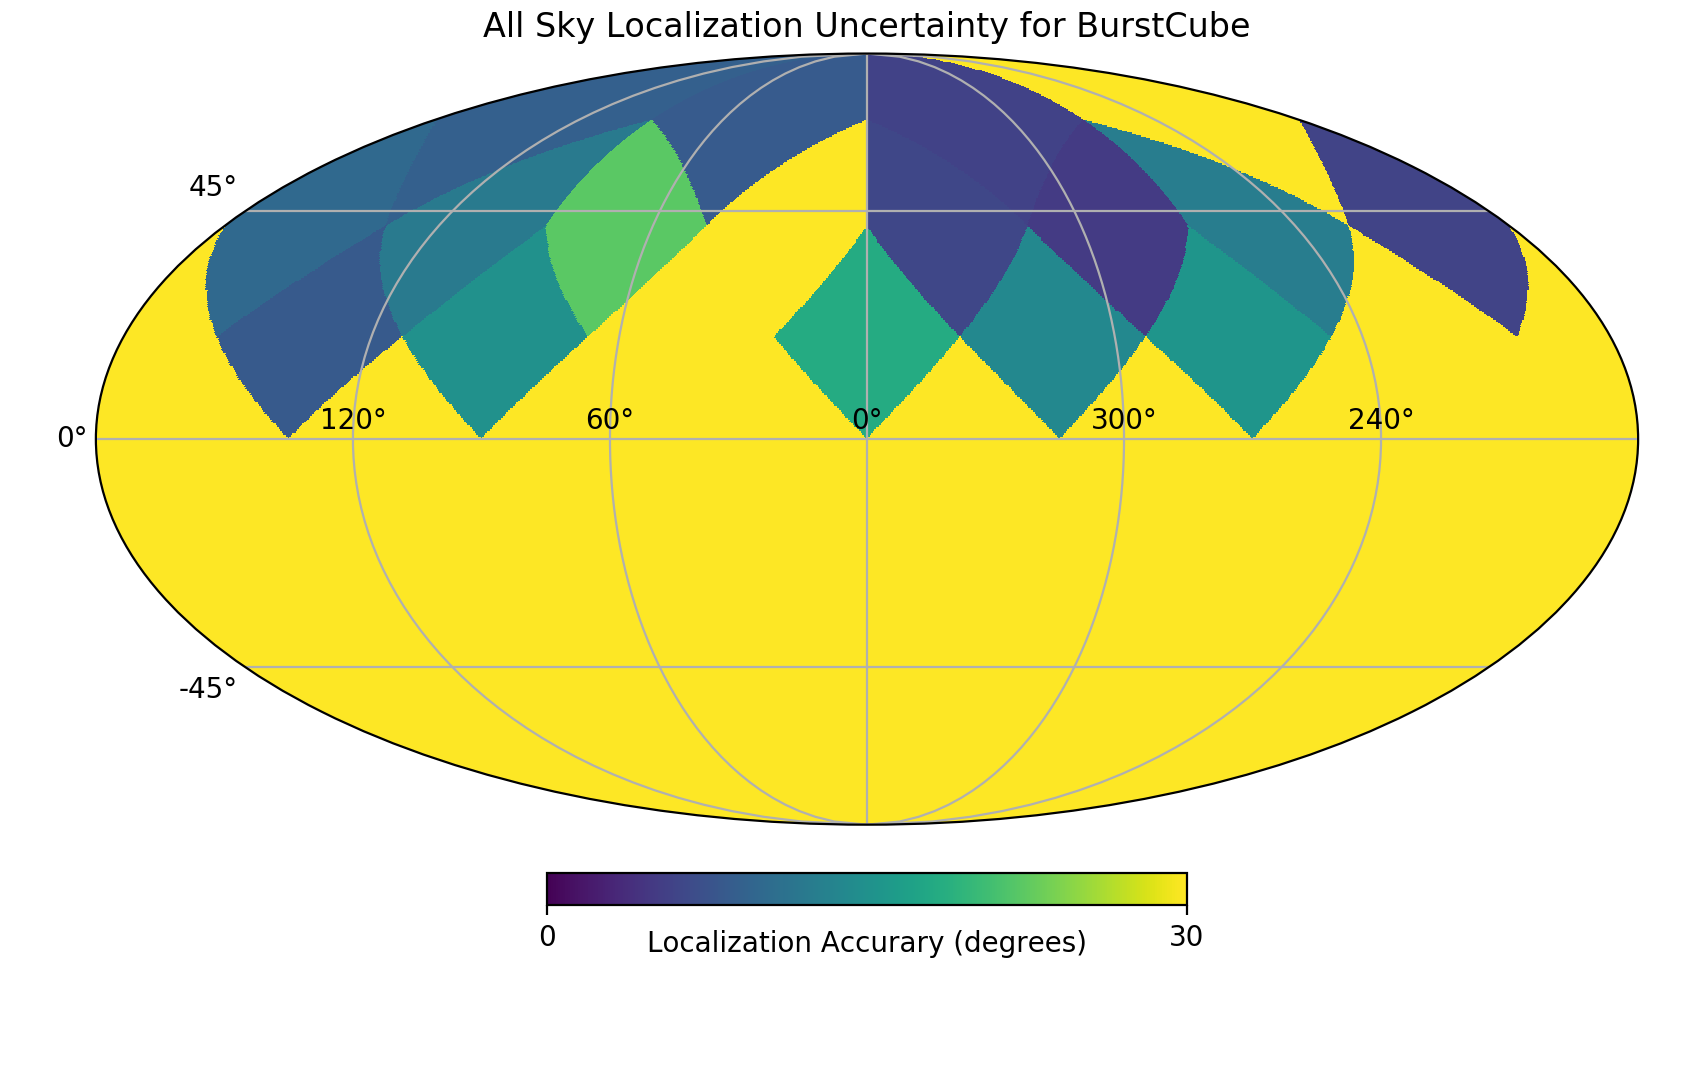

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/healpy/newvisufunc.py:111: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  washold = ax.ishold()
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/healpy/newvisufunc.py:167: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(washold)


In [17]:
angoffset = mynewsim(2,3,500,1000,4,45,30,alternating=True)